In [425]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Question 1

I downloaded the data from https://www.alphavantage.co/ using the link and query parameters 

In [36]:
# Get the data

dfs = {}

for file_name in glob.glob('*.csv'):
    dfs[file_name.replace('daily_','').replace('.csv','')] = \
                                pd.read_csv(file_name, parse_dates=True, index_col='timestamp')

In [37]:
# Trim for leaving 10 years only

for key in dfs:
    dfs[key] = dfs[key][:dfs[key].index.max() - pd.DateOffset(years=10)]

In [38]:
dfs['FB'].head()

,open,high,low,close,volume
timestamp,,,,,
2020-08-21,268.690,270.4900,266.42,267.01,15538615
2020-08-20,261.500,269.6300,261.46,269.01,20299688
2020-08-19,261.388,267.9080,261.35,262.59,23291463
2020-08-18,260.950,265.1500,259.26,262.34,18690383
2020-08-17,262.500,264.0973,259.40,261.16,13303174


## Question 2

In [77]:
# Calculate returns and look at some statistics

for key in dfs:
    dfs[key]['r'] = dfs[key].close.shift(1) / dfs[key].close - 1
    dfs[key].dropna(inplace=True)
    print(key)
    print(dfs[key].r.describe())

FB
count    2078.000000
mean        0.001209
std         0.023520
min        -0.189609
25%        -0.009080
50%         0.001091
75%         0.012063
max         0.296077
Name: r, dtype: float64
GOOG
count    1613.000000
mean        0.000780
std         0.016452
min        -0.111008
25%        -0.006256
50%         0.000819
75%         0.008715
max         0.160524
Name: r, dtype: float64
AAPL
count    2517.000000
mean        0.000861
std         0.024424
min        -0.854857
25%        -0.006919
50%         0.000905
75%         0.010109
max         0.119808
Name: r, dtype: float64


FB


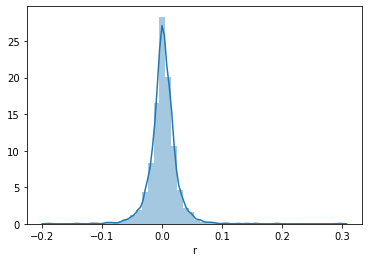

GOOG


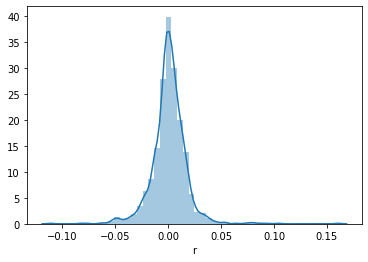

AAPL


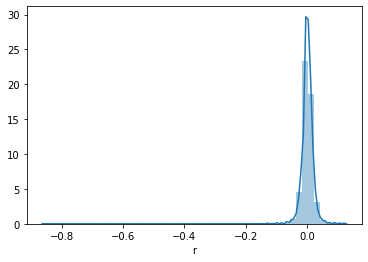

In [381]:
# plot the densities

for key in dfs:
    print(key)
    sns.distplot(dfs[key].r)
    plt.show()

To check whether the timeseries are stationary I run Dickey-Fuller test and look at the plots (in case of changing autocorrelation - DF test works mostly with trends and cycles)

FB


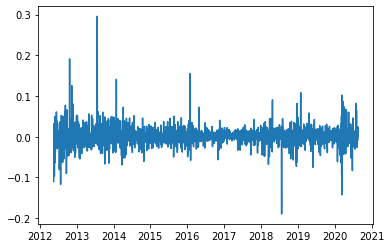

FB's p_value = 4.919375732713266e-27, timeseries is stationary
GOOG


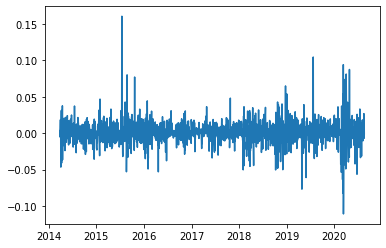

GOOG's p_value = 4.7459676556631304e-15, timeseries is stationary
AAPL


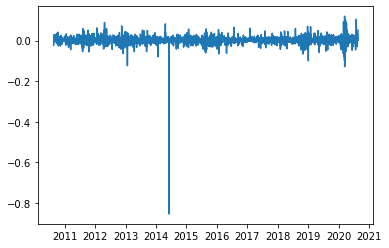

AAPL's p_value = 0.0, timeseries is stationary


In [63]:
# Stationarity check

for key in dfs:
    print(key)
    plt.plot(dfs[key].r)
    plt.show()
    p_val = adfuller(dfs[key].r.dropna())[1]
    if p_val < 0.05:
        print("{}'s p_value = {}, timeseries is stationary".format(key, p_val))
    else:
        print("{}'s p_value = {}, timeseries is not stationary".format(key, p_val))

We can consider these timeseries as stationary

FB


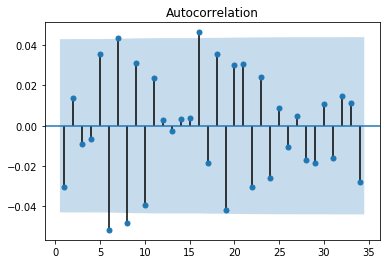

GOOG


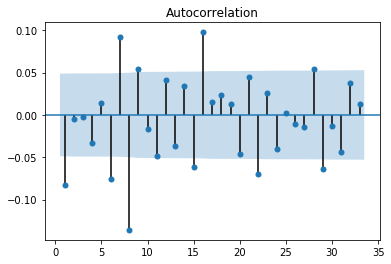

AAPL


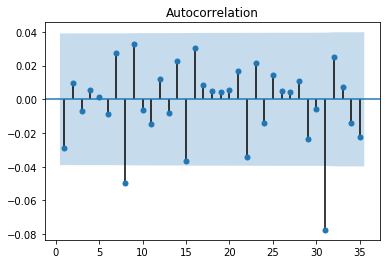

In [69]:
# Autocorrelations

for key in dfs:
    print(key)
    plot_acf(dfs[key].r.dropna(), zero=False)
    plt.show()

FB


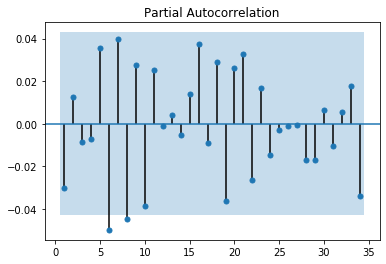

GOOG


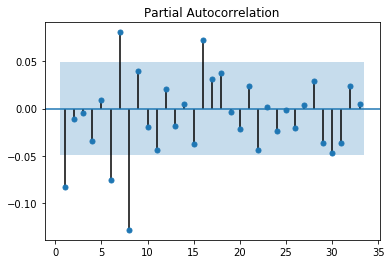

AAPL


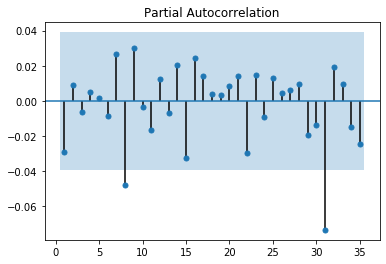

In [71]:
# Partial autocorrelations

for key in dfs:
    print(key)
    plot_pacf(dfs[key].r, zero=False)
    plt.show()

We can see that there are some p-values > 0.05 telling us about autocorrelations. But when we have real strong autocorrelation the plot_acf is smooth and long-tailed which is not the case. So it can be weak autocorrelation for Google but in general I would say the timeseries are not autocorrelated. To be sure we also can run Durbin-Watson test.

In [429]:
for key in dfs:
    print(key, durbin_watson(dfs[key].r))

FB 2.0442202028659056
GOOG 2.159454285828555
AAPL 2.0530757997202542


Let's look at some relationships between returns

In [393]:
# Pearsons correlations

df = pd.concat([dfs['FB'].r, dfs['GOOG'].r, dfs['AAPL'].r], axis=1).dropna()
df.columns = ['fb','goog','aapl']

In [394]:
df.corr()

,fb,goog,aapl
fb,1.000000,0.652364,0.343969
goog,0.652364,1.000000,0.365294
aapl,0.343969,0.365294,1.000000


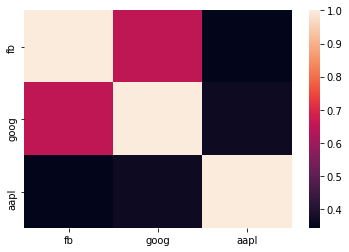

In [396]:
sns.heatmap(df.corr())

The correlations are quite high especially between Google and Facebook

Granger's causality test

In [402]:
grangercausalitytests(df[['fb','goog']], maxlag=np.arange(1,15))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5975  , p=0.1072  , df_denom=1609, df_num=1
ssr based chi2 test:   chi2=2.6023  , p=0.1067  , df=1
likelihood ratio test: chi2=2.6002  , p=0.1068  , df=1
parameter F test:         F=2.5975  , p=0.1072  , df_denom=1609, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3561  , p=0.2580  , df_denom=1606, df_num=2
ssr based chi2 test:   chi2=2.7206  , p=0.2566  , df=2
likelihood ratio test: chi2=2.7183  , p=0.2569  , df=2
parameter F test:         F=1.3561  , p=0.2580  , df_denom=1606, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9459  , p=0.4176  , df_denom=1603, df_num=3
ssr based chi2 test:   chi2=2.8501  , p=0.4153  , df=3
likelihood ratio test: chi2=2.8476  , p=0.4157  , df=3
parameter F test:         F=0.9459  , p=0.4176  , df_denom=1603, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6732  , p=0.

{1: ({'ssr_ftest': (2.597466247070707, 0.10723083449809374, 1609.0, 1),
   'ssr_chi2test': (2.6023092543679174, 0.10670813087708944, 1),
   'lrtest': (2.6002110117915436, 0.10684948792008882, 1),
   'params_ftest': (2.597466247070529, 0.10723083449810589, 1609.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3560897722741034, 0.25796122613369604, 1606.0, 2),
   'ssr_chi2test': (2.7206234410131764, 0.2565807829946691, 2),
   'lrtest': (2.718328757859126, 0.256875337740005, 2),
   'params_ftest': (1.3560897722740002, 0.2579612261336959, 1606.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.9459178321692902, 0.4175869793056103, 1603.0, 3),
   'ssr_chi2test': (2.8501454331738434, 0.41531147237383526, 3),
   'lrtest': (2.8476256335852668, 0.4157197785395309, 3),
   'params_ftest': (0.9459178321693584, 0.4175869793055832, 1603.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [406]:
grangercausalitytests(df[['fb','aapl']], maxlag=np.arange(1,15))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.6223 , p=0.0000  , df_denom=1609, df_num=1
ssr based chi2 test:   chi2=28.6756 , p=0.0000  , df=1
likelihood ratio test: chi2=28.4236 , p=0.0000  , df=1
parameter F test:         F=28.6223 , p=0.0000  , df_denom=1609, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.4565 , p=0.0000  , df_denom=1606, df_num=2
ssr based chi2 test:   chi2=29.0031 , p=0.0000  , df=2
likelihood ratio test: chi2=28.7451 , p=0.0000  , df=2
parameter F test:         F=14.4565 , p=0.0000  , df_denom=1606, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.0245 , p=0.0000  , df_denom=1603, df_num=3
ssr based chi2 test:   chi2=30.2048 , p=0.0000  , df=3
likelihood ratio test: chi2=29.9250 , p=0.0000  , df=3
parameter F test:         F=10.0245 , p=0.0000  , df_denom=1603, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.6503  , p=0.

{1: ({'ssr_ftest': (28.62227391727907, 1.006277607986774e-07, 1609.0, 1),
   'ssr_chi2test': (28.675640493880586, 8.557340652158846e-08, 1),
   'lrtest': (28.423571983961665, 9.747126959798294e-08, 1),
   'params_ftest': (28.62227391727911, 1.006277607986774e-07, 1609.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (14.45654276078672, 5.990312598020534e-07, 1606.0, 2),
   'ssr_chi2test': (29.003101354455048, 5.035661881966393e-07, 2),
   'lrtest': (28.74511925063598, 5.728971528166118e-07, 2),
   'params_ftest': (14.456542760786778, 5.990312598020534e-07, 1606.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (10.02450782859943, 1.5173433726653468e-06, 1603.0, 3),
   'ssr_chi2test': (30.20484891586728, 1.2496914167625923e-06, 3),
   'lrtest': (29.925010293029118, 1.4311015568894575e-06, 3),
   'params_ftest': (10.024507828599534, 1.5173433726650664e-06, 1603.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 

In [407]:
grangercausalitytests(df[['goog','aapl']], maxlag=np.arange(1,15))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0813  , p=0.0435  , df_denom=1609, df_num=1
ssr based chi2 test:   chi2=4.0889  , p=0.0432  , df=1
likelihood ratio test: chi2=4.0837  , p=0.0433  , df=1
parameter F test:         F=4.0813  , p=0.0435  , df_denom=1609, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2705  , p=0.0382  , df_denom=1606, df_num=2
ssr based chi2 test:   chi2=6.5613  , p=0.0376  , df=2
likelihood ratio test: chi2=6.5480  , p=0.0379  , df=2
parameter F test:         F=3.2705  , p=0.0382  , df_denom=1606, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2579  , p=0.0799  , df_denom=1603, df_num=3
ssr based chi2 test:   chi2=6.8032  , p=0.0784  , df=3
likelihood ratio test: chi2=6.7888  , p=0.0789  , df=3
parameter F test:         F=2.2579  , p=0.0799  , df_denom=1603, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7936  , p=0.

{1: ({'ssr_ftest': (4.0813065600009555, 0.04352554109104252, 1609.0, 1),
   'ssr_chi2test': (4.088916205544773, 0.04316531214628527, 1),
   'lrtest': (4.0837390912001865, 0.0432977452806427, 1),
   'params_ftest': (4.08130656000124, 0.0435255410910391, 1609.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.2704777714049134, 0.03824143140298406, 1606.0, 2),
   'ssr_chi2test': (6.561319663428786, 0.03760343667943175, 2),
   'lrtest': (6.5479942819602, 0.03785481324080306, 2),
   'params_ftest': (3.270477771405247, 0.038241431402969935, 1606.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2578645495370497, 0.07990333965087867, 1603.0, 3),
   'ssr_chi2test': (6.803172660177137, 0.07844308373121782, 3),
   'lrtest': (6.788839371933136, 0.0789415657048011, 3),
   'params_ftest': (2.2578645495370817, 0.07990333965086992, 1603.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

Based on p-values we can see that there are some relations between Google and Facebook / Google and Apple

## Question 3

In [417]:
# Function to plot generated pnl

def plot_pnl(key, n_plots=3):
    for _ in range(n_plots):
        pnl = np.random.normal(size=dfs[key].r.shape[0]) * dfs[key].r
        fig, (ax1, ax2) = plt.subplots(2, 1)
        ax1.plot(pnl)
        ax1.set_title(key + "'s PNL")
        ax1.set_ylabel('pnl')
        ax2.plot(np.cumsum(pnl), color='g')
        ax2.set_ylabel('pnl cummulative')
        plt.show()

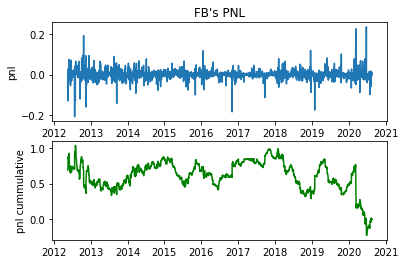

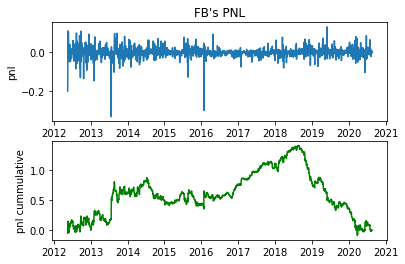

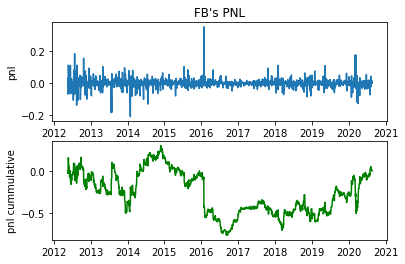

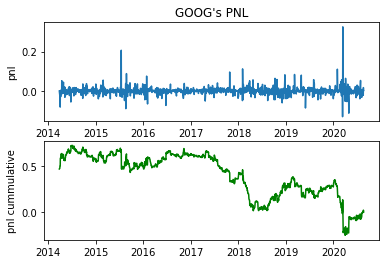

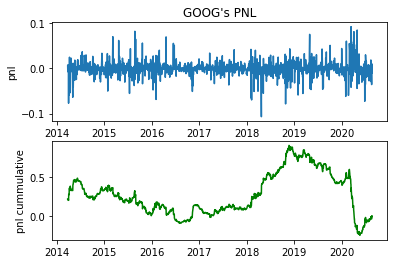

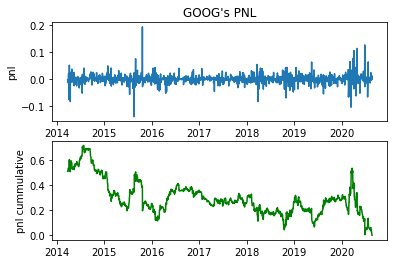

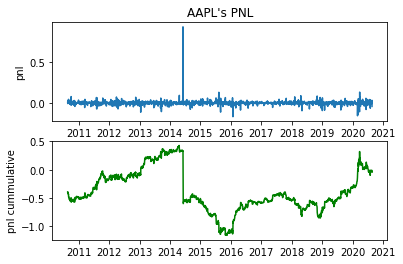

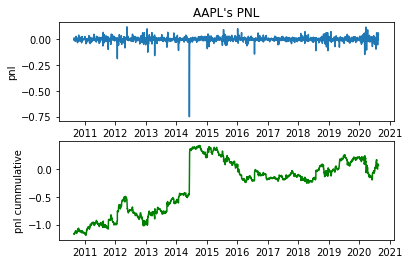

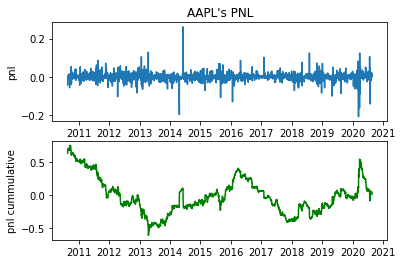

In [420]:
# Draw some examples of pnl with randomly generated f

for key in dfs:
    plot_pnl(key)

## Question 4

Since I have to find conditional distribution of SR (with given fixed hit rate), I generate samples with different fixed hit rates and look at distributions for each hit rate value

In [430]:
# function for generation SRs with fixed hit rate

def sr_distr_hit_rate(key, hit_rate, steps=100):
    n = dfs[key].shape[0]
    n_match = int(hit_rate * n)
    match_vals = [1] * n_match + [-1] * (n - n_match)
    signs = np.where(dfs[key].r > 0, 1, -1)
    
    srs = []
    for _ in range(steps):
        np.random.shuffle(match_vals)
        pnl = signs * match_vals * abs(np.random.normal(size=n)) * dfs[key].r.values
        srs.append(np.mean(pnl) / np.std(pnl))
    return srs

In [432]:
# plotting

def plot_sr_distr(key, steps=100):
    sr_mean, sr_min, sr_max = [], [], []
    for hit_rate in np.linspace(0, 1, 10):
        srs = sr_distr(key, hit_rate, steps)
        sr_mean.append(np.mean(srs))
        sr_min.append(np.mean(srs) - 2 * np.std(srs))
        sr_max.append(np.mean(srs) + 2 * np.std(srs))
    plt.plot(np.linspace(0, 1, 10), sr_mean)
    plt.title(key + "'s SR distributions given hit rate")
    plt.xlabel('hit rate')
    plt.ylabel('SR')
    plt.fill_between(np.linspace(0, 1, 10), sr_min, sr_max, alpha=0.2)
    plt.show()

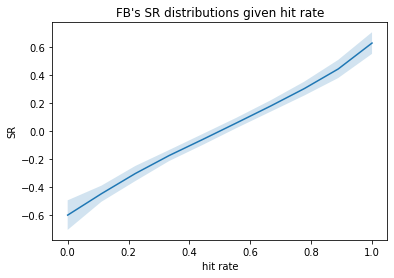

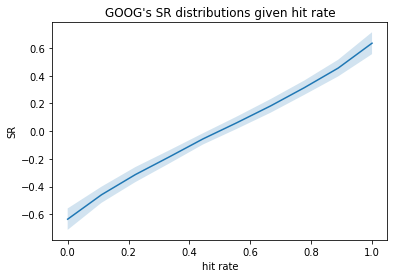

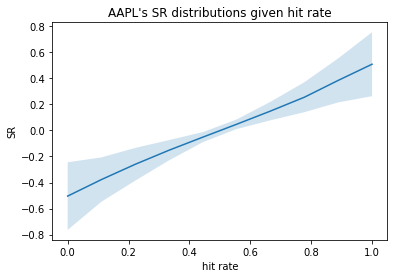

In [433]:
for key in dfs:
    plot_sr_distr(key)

## Question 5

It's difficult to fix rmse and mae and generate samples with particular value of the metric. So I generate samples with rmse/mae approximately equal to fixed value by generating differences from return first (add some normal distributed value with mean=shift and different signs). With this approach functions for rmse and mae are the same

In [362]:
def sr_distr_rmse(key, rmse, steps=100):
    n = dfs[key].shape[0]
    srs = []
    for _ in range(steps):
        diffs = np.random.choice([-1,1], size=n) * abs(np.random.normal(loc=rmse, scale=0.1, size=n))
        pnl = (dfs[key].r.values - diffs) * dfs[key].r.values
        srs.append(np.mean(pnl) / np.std(pnl))
    return np.array(srs)

In [364]:
def sr_distr_mae(key, mae, steps=100):
    n = dfs[key].shape[0]
    srs = []
    for _ in range(steps):
        diffs = np.random.choice([-1,1], size=n) * abs(np.random.normal(loc=mae, scale=0.1, size=n))
        pnl = (dfs[key].r.values - diffs) * dfs[key].r.values
        srs.append(np.mean(pnl) / np.std(pnl))
    return np.array(srs)

In [438]:
# Transform previous plot function to be able plot distributions with any metric fixed

def plot_sr_distr(key, metric, steps=100):
    sr_mean, sr_min, sr_max = [], [], []
    if metric == 'hit_rate':
        x, func = np.linspace(0, 1, 20), sr_distr_hit_rate
    elif metric == 'rmse':
        x, func = np.linspace(0, 5, 20), sr_distr_rmse
    else:
        x, func = np.linspace(0, 5, 20), sr_distr_mae
    for m in x:
        srs = func(key, m, steps)
        sr_mean.append(np.mean(srs))
        sr_min.append(np.mean(srs) - 2 * np.std(srs))
        sr_max.append(np.mean(srs) + 2 * np.std(srs))
    plt.plot(x, sr_mean)
    plt.title(key + "'s SR distributions given {}".format(metric))
    plt.xlabel(metric)
    plt.ylabel('SR')
    plt.fill_between(x, sr_min, sr_max, alpha=0.2)
    plt.show()

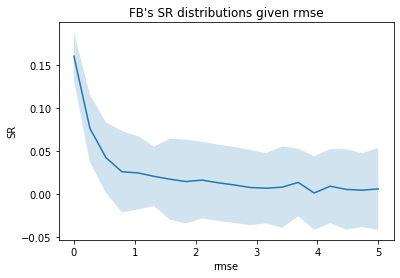

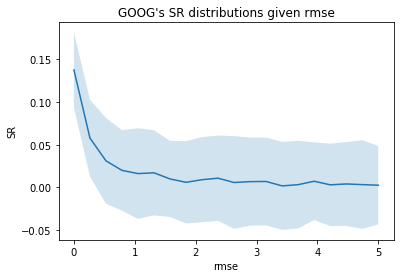

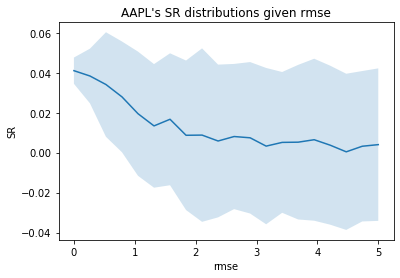

In [440]:
for key in dfs:
    plot_sr_distr(key, 'rmse')

The distributions plots changed because deviations can be with high or low hit rate so the result differ a lot and it's mean is close to zero